# Image segmenter

In [17]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# CLIP 모델과 프로세서 로드
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

def predict_text_from_image(image_path, text_labels):
    """
    이미지 경로와 텍스트 레이블 목록을 받아서, 이미지에 가장 적합한 텍스트 레이블을 예측합니다.
    """
    # 이미지 로드 및 전처리
    image = Image.open(image_path)
    inputs = processor(text=text_labels, images=image, return_tensors="pt", padding=True)

    # 모델을 통해 이미지와 텍스트의 유사도 계산
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image  # 이미지에 대한 로짓

    # 수정 후
    probs = logits_per_image.softmax(dim=1).detach().cpu().numpy()


    # 가장 높은 확률을 가진 텍스트 레이블을 찾음
    max_index = probs.argmax()
    predicted_label = text_labels[max_index]

    return predicted_label

# 분석할 이미지 경로
image_path = "IMG_20150215_233132.jpg"  # 분석할 이미지 경로를 여기에 입력하세요.

# 제로샷 예측을 위한 텍스트 레이블 목록
text_labels = ["eiffel", "danang", "hanoi"]  # 여기에 가능한 텍스트 레이블을 입력하세요.

# 예측 실행
predicted_label = predict_text_from_image(image_path, text_labels)
print(f"예측된 텍스트: {predicted_label}")

예측된 텍스트: eiffel


## Image segmentation 예시

E:\ProgramData\anaconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E:\ProgramData\anaconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\ProgramData\anaconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


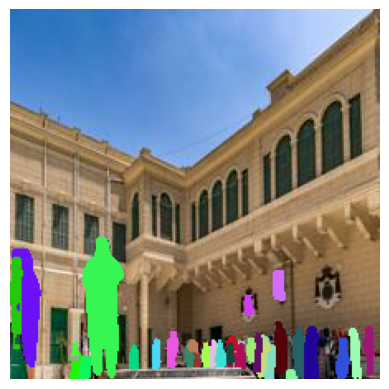

In [2]:
import torch
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

# 이미지 불러오기
image_path = "./data/Abdeen_Palace/15.jpg"
image = Image.open(image_path).convert("RGB")

# 모델 불러오기
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # 모델을 평가 모드로 설정

# 이미지 전처리
transform = T.Compose([T.ToTensor()])
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

# 세그멘테이션 수행
with torch.no_grad():
    prediction = model(input_batch)

# 결과 딕셔너리에서 마스크 정보 가져오기
masks = prediction[0]['masks']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

# 이미지를 numpy 배열로 변환
np_image = np.array(image)

# 객체의 수
num_objects = min(len(scores), masks.size(0))

# 확률 임계값
confidence_threshold = 0.1

# 각 객체에 대해 마스크를 이미지에 적용
for i in range(num_objects):
    # 점수가 임계값보다 높은 객체만 처리
    if scores[i] > confidence_threshold:
        mask = masks[i, 0]
        label = labels[i].item()

        # 사람 클래스가 아닌 경우에만 색상 적용
        if label != 0:  # 'person_label_id'는 사람 객체의 레이블 ID(COCO에서는 0을 사용)입니다.
            # 무작위 색상 생성
            color = [random.randint(0, 255) for _ in range(3)]
            # 마스크에 색상 적용
            np_image[mask > 0.5] = color

# 색상이 적용된 이미지 생성
segmented_image = Image.fromarray(np_image)

# 결과 이미지 출력
plt.imshow(segmented_image)
plt.axis('off')  # 축 제거
plt.show()

- 위와 같이 모델이 사람 클래스를 상대적으로 잘 segmentation하는것을 알 수 있습니다.
- 다만 위 이미지는 이해를 돕기 위한 예제 이미지로 실제로 이미지 검색을 위해 벡터화를 할때는 이러한 사람이미지를 완전히 제거해야 합니다.

## Image Segmentator 생성

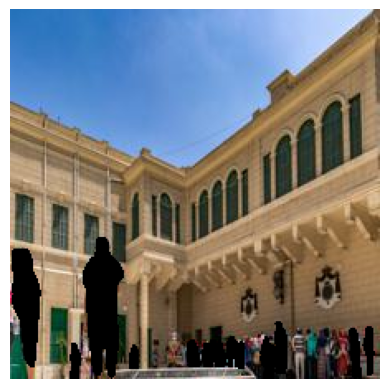

In [3]:
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

def predict_image(input_batch):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    with torch.no_grad():
        prediction = model(input_batch)
    return prediction


def mask_people_in_image(image, prediction, confidence_threshold=0.5):
    masks = prediction[0]['masks']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    np_image = np.array(image)
    num_objects = min(len(scores), masks.size(0))
    
    for i in range(num_objects):
        if scores[i] > confidence_threshold and labels[i].item() == 1:  # COCO에서 사람 클래스 ID는 1입니다.
            mask = masks[i, 0]
            np_image[mask > 0.5] = [0, 0, 0]  # 검은색으로 마스킹
    return Image.fromarray(np_image)

def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
# 이미지 전처리, 예측 및 마스킹을 위한 통합 함수
def preprocess_and_mask_image(image_path, confidence_threshold=0.1):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    input_tensor = transform(image).unsqueeze(0)
    
    # Mask R-CNN 모델 로딩 및 예측
    mask_model = maskrcnn_resnet50_fpn(pretrained=True).eval()
    with torch.no_grad():
        prediction = mask_model(input_tensor)
    
    # 사람 마스킹 처리
    masks = prediction[0]['masks']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    np_image = np.array(image)
    
    for i in range(len(scores)):
        if scores[i] > confidence_threshold and labels[i].item() == 1:
            mask = masks[i, 0]
            np_image[mask > 0.5] = [0, 0, 0]
    
    return Image.fromarray(np_image)

# 이미지 파일 경로 설정
image_path = "./data/Abdeen_Palace/15.jpg"

# 이미지를 불러와 전처리하는 함수 호출
input_batch = load_and_preprocess_image(image_path)

# 이미지를 예측하여 마스크 생성하는 함수 호출
prediction = predict_image(input_batch)

# 원본 이미지를 RGB 모드로 불러오기
original_image = Image.open(image_path).convert("RGB")

# 예측된 마스크를 사용하여 이미지에서 사람 영역을 마스킹하는 함수 호출
# 여기서 confidence_threshold 매개변수를 0.5로 설정 (이전 코드에서는 잘못된 위치에 있었음)
masked_image = mask_people_in_image(original_image, prediction, confidence_threshold=0.5)

# 마스킹된 이미지를 화면에 표시하는 함수 호출
display_image(masked_image)

# Image Vectorizer(feat. CLIP)

In [4]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image


def image_to_vector(image_path):
    # 이미지에서 사람을 제거한 후 CLIP 모델로 벡터화
    masked_image = preprocess_and_mask_image(image_path)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    
    # 이미지 전처리
    inputs = processor(images=masked_image, return_tensors="pt")
    
    # 이미지 벡터 추출 (텍스트 입력 없이 이미지만 처리)
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    
    # 벡터를 numpy 배열로 변환
    vector = image_features.detach().cpu().numpy().squeeze()
    return vector

In [5]:
image_path = "./data/Abdeen_Palace/15.jpg"
vector = image_to_vector(image_path)
print(vector)

[ 5.93761578e-02  2.47398481e-01 -2.42573559e-01 -1.16108350e-01
  1.13122202e-02 -1.26163006e-01  2.19734043e-01 -4.61897254e-03
 -2.76604354e-01  2.12529480e-01  1.73324913e-01  1.15208969e-01
  2.33469069e-01  1.67498484e-01 -1.86835781e-01  1.82086706e-01
 -3.76926184e-01  1.59702361e-01  4.71240878e-02 -3.84412408e-01
  2.63545275e-01 -2.21318558e-01  2.48941436e-01 -6.67863488e-01
 -1.34216547e-01  6.12678170e-01  1.60510451e-01  1.89460754e-01
 -1.48974344e-01  1.96978986e-01 -1.31157428e-01  2.16310173e-01
  1.89970881e-02 -4.07431036e-01 -3.35270196e-01 -4.60667014e-02
 -8.65799189e-03  2.23295823e-01 -1.58113509e-01  8.65552187e-01
  2.26045310e-01  7.00817108e-01 -2.28274971e-01  1.14464119e-01
  5.52146435e-02 -2.99853086e-03 -3.91690433e-01  2.74527743e-02
 -2.06421688e-01 -2.46665835e-01  4.05771971e-01  3.98965776e-01
 -1.72155514e-01 -2.14583874e-01 -4.44276989e-01  3.96422595e-01
  2.00434566e-01  2.29873359e-02  2.21624136e-01  4.19908136e-01
  4.48615253e-02  1.62342

# 데이터셋 벡터DB화

In [6]:
import os
from glob import glob
from tqdm import tqdm
import chromadb

# chromadb 초기화 및 컬렉션 생성
client = chromadb.Client()
collection = client.create_collection("travel")

# 이미지 파일 검색
img_list = sorted(glob("./data/*/*.jpg"))

print(f"Total images: {len(img_list)}")

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)):
    # os 모듈을 사용하여 경로에서 라벨명 추출
    label_name = os.path.basename(os.path.dirname(img_path))
    # 파일명 (여기서는 숫자) 추출
    file_name = os.path.basename(img_path)
    
    # 이미지를 벡터화
    embedding = image_to_vector(img_path)
    
    # 임베딩과 메타데이터 추가
    embeddings.append(embedding)
    metadatas.append({
        "uri": img_path,
        "label": label_name,
        "file_name": file_name
    })
    
    # 이미지 인덱스를 ID로 사용
    ids.append(str(i))
    
print("Data convert completed!")

Total images: 375


100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [21:35<00:00,  3.45s/it]

Data convert completed!


In [7]:
# 임베딩(numpy.ndarray)을 list로 변환
embeddings_list = [embedding.tolist() for embedding in embeddings]

# chromadb에 데이터 추가
collection.add(
    embeddings=embeddings_list,  # 임베딩을 list 형태로 추가합니다.
    metadatas=metadatas,         # 메타데이터를 추가합니다.
    ids=ids,                      # 아이디를 추가합니다.
)

print("Data upload completed!")

Data upload completed!


## 이미지 검색

In [8]:
def query(img_path, n_results=3):
    # 이미지 경로로부터 이미지를 로드하고 RGB로 변환합니다.
    test_img = Image.open(img_path).convert("RGB")

    # 이미지를 벡터화합니다.
    test_embedding = image_to_vector(img_path)

    # numpy.array를 리스트로 변환합니다.
    test_embedding_list = test_embedding.tolist()

    # 임베딩을 사용하여 쿼리 결과를 얻습니다.
    query_result = collection.query(
        query_embeddings=[test_embedding_list],  # 리스트로 변환된 임베딩을 사용
        n_results=n_results,
    )

    # 쿼리 이미지와 가장 유사한 이미지들을 시각화합니다.
    fig, axes = plt.subplots(1, n_results + 1, figsize=(20, 5))
    axes[0].imshow(test_img)
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]
        result_img = Image.open(metadata["uri"]).convert("RGB")
        # 'name' 대신 존재하는 키를 사용하여 제목 설정
        label = metadata.get('label', 'Unknown')  # 'name' 키가 없는 경우 'Unknown'을 사용
        axes[i+1].imshow(result_img)
        axes[i+1].set_title(f"{label}\nDistance: {distance:.2f}")
        axes[i+1].axis("off")

    plt.show()
    return query_result

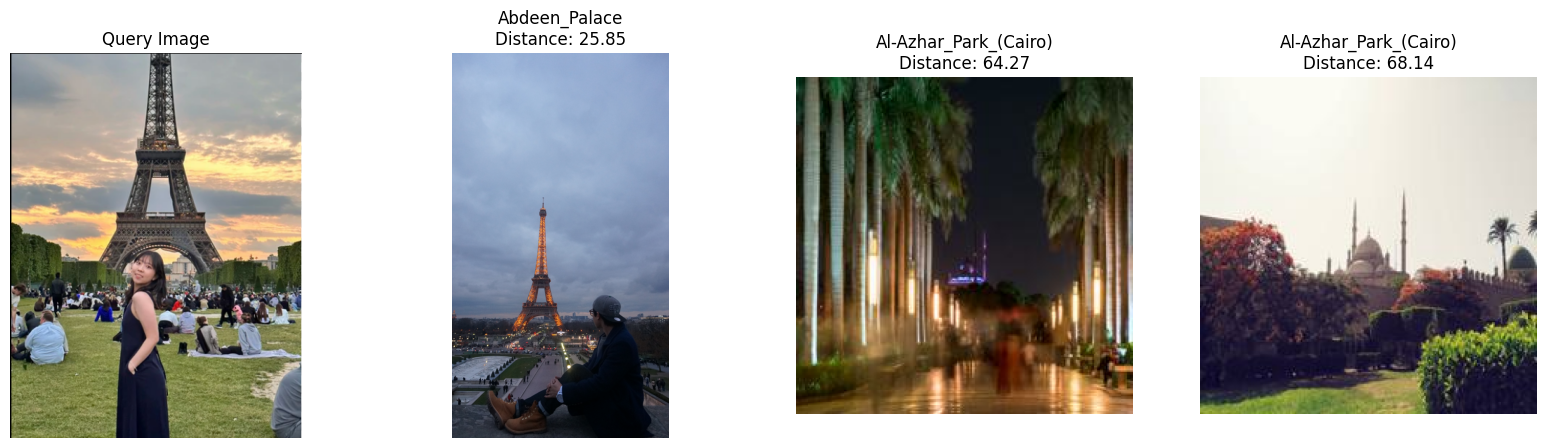

In [10]:
query_result = query("./eiffel.png", n_results=3)

- Query Image로 사용된 파일은 실제 구글에서 검색한 장소 이미지사진중 하나를 활용해 query에 입력한 결과 DB내에서 가장 유사한 이미지를 잘 찾아주는 것을 확인할 수 있습니다.

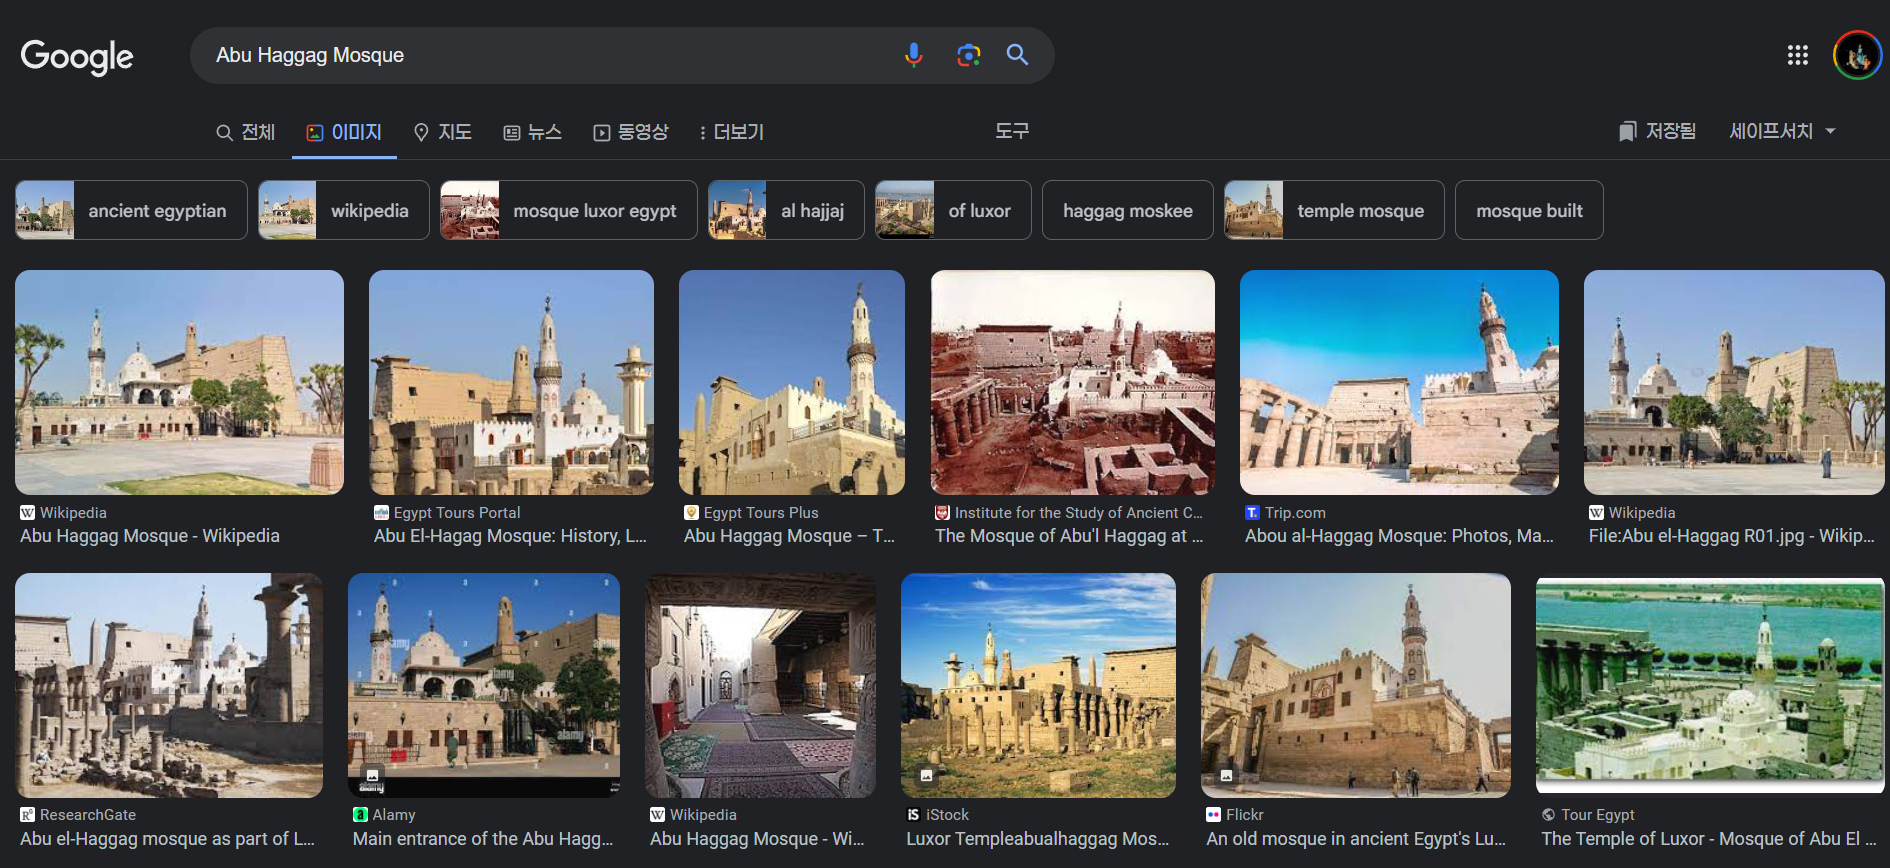

# 벡터DB 시각화

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 예시 데이터와 라벨
# embeddings_list는 여러분의 벡터 데이터 리스트입니다.
# labels는 해당 벡터 데이터의 라벨 목록입니다.
embeddings_array = np.array(embeddings_list)  # 벡터 데이터를 numpy 배열로 변환
labels = [metadata['label'] for metadata in metadatas]  # 메타데이터에서 라벨 추출

# PCA를 사용하여 데이터를 3차원으로 축소
pca = PCA(n_components=3)
embeddings_reduced = pca.fit_transform(embeddings_array)

# 라벨별로 색상 매핑
unique_labels = list(set(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_to_color = {label: color for label, color in zip(unique_labels, colors)}

# 3D 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    idx = [i for i, l in enumerate(labels) if l == label]
    ax.scatter(embeddings_reduced[idx, 0], embeddings_reduced[idx, 1], embeddings_reduced[idx, 2], 
               color=label_to_color[label], label=label, s=15)

# 축의 배경색을 투명하게 설정하여 그리드 제거
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# 축의 배경색을 투명하게 설정 (RGBA 형식으로 투명도 설정)
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

plt.show()